In [12]:
import os
import sys

REPO_DIRECTORY = f"{os.getcwd()}/../.."
sys.path.append(REPO_DIRECTORY)

In [89]:
import coconut
import dataset
import json
import pandas as pd
import re
import torch
import transformers
import tqdm

In [ ]:
MODEL_ARCHITECTURE = "openai-community/gpt2"
CHECKPOINT = 15
GPU_ID = 0
MAX_NEW_TOKENS = 100
N_SEQUENCES = 15

In [16]:
model = transformers.AutoModelForCausalLM.from_pretrained(MODEL_ARCHITECTURE)
checkpoint = f"{REPO_DIRECTORY}/checkpoints/gsm-cot/checkpoint_{CHECKPOINT}"
weights = torch.load(checkpoint, torch.device(GPU_ID), weights_only=False)
model.load_state_dict(weights, strict=False)
model = model.to(GPU_ID)

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_ARCHITECTURE)
tokenizer.pad_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [90]:
with open(f"{REPO_DIRECTORY}/data/gsm_test.json") as file:
    test_data = json.load(file)

In [86]:
df = pd.DataFrame()

for sample_id, sample in tqdm.tqdm(enumerate(test_data)):

    tokens = tokenizer(sample["question"], return_tensors="pt").to(GPU_ID)
    outputs = model.generate(
        **tokens, 
        max_new_tokens=MAX_NEW_TOKENS, 
        num_beams=N_SEQUENCES, 
        num_return_sequences=N_SEQUENCES,
    )

    rationales_seen = set()
    for output_id, output in enumerate(outputs):
        text_output = tokenizer.decode(output)

        if "<|endoftext|>" not in text_output:
            break

        rationales = None
        match = re.search(r"<<.*?###", text_output, re.DOTALL)
        if match:
            rationales = match.group(0).rstrip("\n###")
        if rationales in rationales_seen:
            break
        rationales_seen.add(rationales)
        answer = re.search(r"### (.*?)<\|endoftext\|>", text_output).group(1)

        entry = pd.DataFrame({
            "Question ID": sample_id,
            "Chain of Thought ID": output_id,
            "Question": sample["question"],
            "Rationales": rationales,
            "Answer": answer,
            "Target Rationales": "\n".join(sample["steps"]),
            "Target Answer": sample["answer"],
            "Correct": answer == sample["answer"],
            "Raw Output": text_output,
        }, index=[len(df)])

        df = pd.concat([df, entry])


group = df.groupby("Question ID")["Correct"].sum()
group = group[group > 0]
df = df[df["Question ID"].isin(group.index)]

1319it [09:48,  2.24it/s]


In [88]:
directory = f"./data/chains-of-thoughts/{MODEL_ARCHITECTURE}"
os.makedirs(directory, exist_ok=True)
df.to_pickle(f"{directory}/checkpoint_{CHECKPOINT}.pkl")

In [92]:
df.iloc[0]["Question"]

"Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?"

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

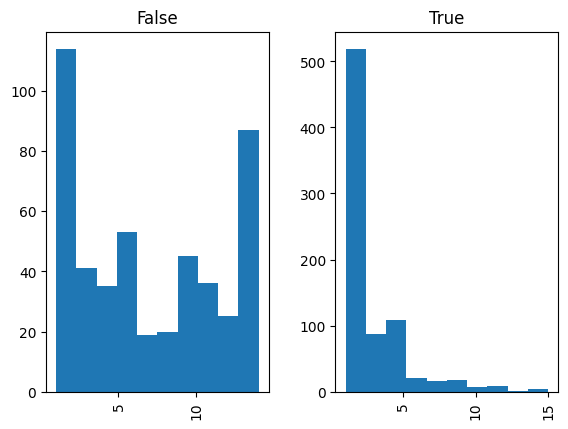

In [85]:
df2.groupby(["Question ID", "Correct"]).size().hist(by="Correct")